# NB04: Cross-Organism Synthesis and Figures

Meta-analysis across all organisms, phylogenetic controls, and publication figures.

**Runs locally.** Requires results from NB02 and NB03.

### Figures
1. Main result: phi vs prevalence for cofit vs random pairs
2. Operon control: excluding adjacent gene pairs
3. Phylogenetic control: phi stratified by genome distance
4. Cofit strength predicts co-occurrence strength
5. Module co-inheritance scores vs null
6. Functional interpretation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

DATA_DIR = Path('../data')
CONS_DIR = Path('../../conservation_vs_fitness/data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load results
combined = pd.read_csv(DATA_DIR / 'all_phi_results.tsv', sep='\t',
                        dtype={'locusId1': str, 'locusId2': str})
print(f"Combined results: {len(combined):,} pairs from {combined['orgId'].nunique()} organisms")
print(f"  Cofit: {combined['is_cofit'].sum():,}")
print(f"  Random: {(~combined['is_cofit']).sum():,}")

# Load module results if available
module_path = DATA_DIR / 'module_coinheritance.tsv'
module_df = pd.read_csv(module_path, sep='\t') if module_path.exists() else None
if module_df is not None:
    print(f"Module results: {len(module_df)} modules")

# Load SEED annotations
seed = pd.read_csv(CONS_DIR / 'seed_annotations.tsv', sep='\t')
seed['locusId'] = seed['locusId'].astype(str)
print(f"SEED annotations: {len(seed):,}")

Combined results: 24,788,401 pairs from 9 organisms
  Cofit: 2,253,491
  Random: 22,534,910
Module results: 224 modules
SEED annotations: 125,167


## Figure 1: Co-fitness Predicts Co-occurrence

Main result: smoothed curves of phi vs mean prevalence for cofit pairs vs random pairs.

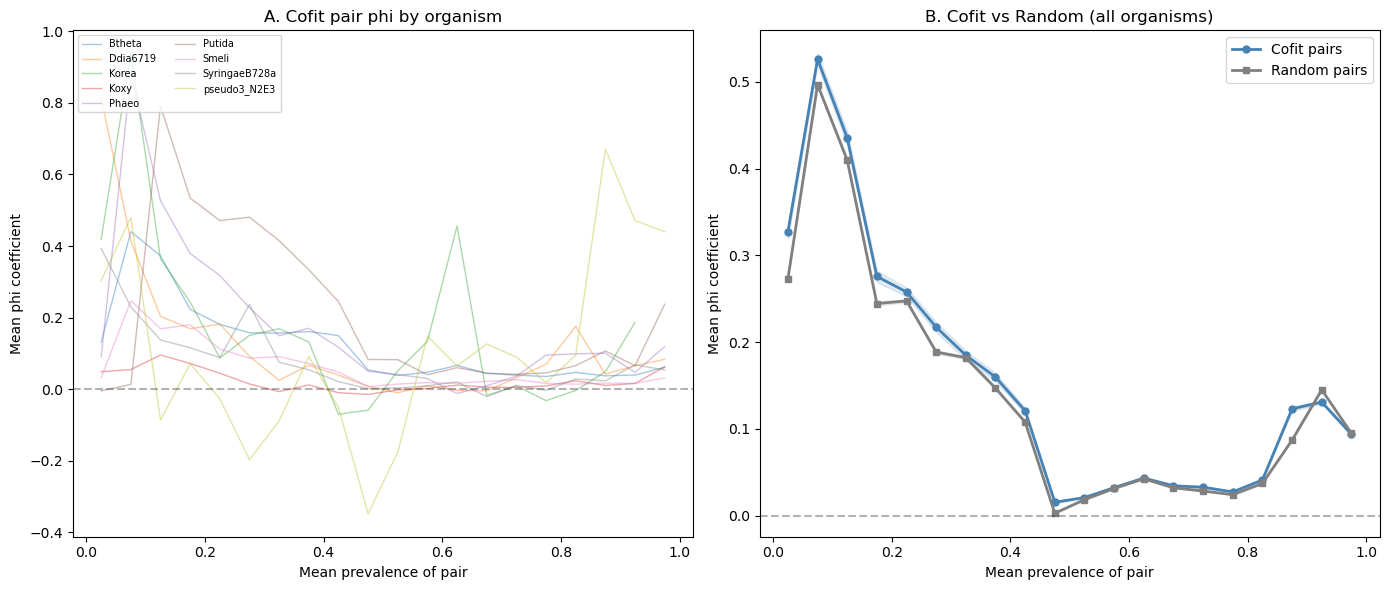


Overall: cofit phi=0.0918, random phi=0.0886
Delta: 0.0032
Mann-Whitney U (two-sided): U=5408733209570, p=1.66e-29


In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prevalence bins
bins = np.arange(0, 1.05, 0.05)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Panel A: Per-organism curves
organisms = sorted(combined['orgId'].unique())
cmap = plt.cm.tab10

for i, orgId in enumerate(organisms):
    org = combined[combined['orgId'] == orgId]
    org_cofit = org[org['is_cofit']]
    org_random = org[~org['is_cofit']]

    org_cofit_binned = org_cofit.groupby(
        pd.cut(org_cofit['mean_prev'], bins=bins)
    )['phi'].mean()
    org_random_binned = org_random.groupby(
        pd.cut(org_random['mean_prev'], bins=bins)
    )['phi'].mean()

    # Only plot bins with data
    valid_cofit = org_cofit_binned.dropna()
    valid_random = org_random_binned.dropna()

    x_cofit = [bin_centers[j] for j in range(len(bin_centers))
               if j < len(org_cofit_binned) and not np.isnan(org_cofit_binned.iloc[j])]
    y_cofit = valid_cofit.values

    axes[0].plot(x_cofit[:len(y_cofit)], y_cofit, '-', color=cmap(i % 10),
                 alpha=0.4, linewidth=1, label=orgId)

axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Mean prevalence of pair')
axes[0].set_ylabel('Mean phi coefficient')
axes[0].set_title('A. Cofit pair phi by organism')
axes[0].legend(fontsize=7, loc='upper left', ncol=2)

# Panel B: Aggregated cofit vs random
combined['prev_bin'] = pd.cut(combined['mean_prev'], bins=bins)

cofit_binned = combined[combined['is_cofit']].groupby('prev_bin')['phi'].agg(['mean', 'sem', 'count'])
random_binned = combined[~combined['is_cofit']].groupby('prev_bin')['phi'].agg(['mean', 'sem', 'count'])

# Filter bins with sufficient data
min_count = 10
cofit_valid = cofit_binned[cofit_binned['count'] >= min_count]
random_valid = random_binned[random_binned['count'] >= min_count]

x_cofit = [bin_centers[i] for i in range(len(bin_centers))
           if cofit_binned.index[i] in cofit_valid.index] if len(cofit_valid) > 0 else []
x_random = [bin_centers[i] for i in range(len(bin_centers))
            if random_binned.index[i] in random_valid.index] if len(random_valid) > 0 else []

axes[1].plot(x_cofit[:len(cofit_valid)], cofit_valid['mean'].values, 'o-',
             color='steelblue', linewidth=2, markersize=5, label='Cofit pairs')
if len(cofit_valid) > 0:
    axes[1].fill_between(
        x_cofit[:len(cofit_valid)],
        cofit_valid['mean'].values - 1.96 * cofit_valid['sem'].values,
        cofit_valid['mean'].values + 1.96 * cofit_valid['sem'].values,
        alpha=0.15, color='steelblue'
    )

axes[1].plot(x_random[:len(random_valid)], random_valid['mean'].values, 's-',
             color='gray', linewidth=2, markersize=5, label='Random pairs')
if len(random_valid) > 0:
    axes[1].fill_between(
        x_random[:len(random_valid)],
        random_valid['mean'].values - 1.96 * random_valid['sem'].values,
        random_valid['mean'].values + 1.96 * random_valid['sem'].values,
        alpha=0.15, color='gray'
    )

axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Mean prevalence of pair')
axes[1].set_ylabel('Mean phi coefficient')
axes[1].set_title('B. Cofit vs Random (all organisms)')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_cofit_cooccurrence.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
cofit_phi = combined[combined['is_cofit']]['phi'].dropna()
random_phi = combined[~combined['is_cofit']]['phi'].dropna()
u, p = stats.mannwhitneyu(cofit_phi, random_phi, alternative='two-sided')
print(f"\nOverall: cofit phi={cofit_phi.mean():.4f}, random phi={random_phi.mean():.4f}")
print(f"Delta: {cofit_phi.mean() - random_phi.mean():.4f}")
print(f"Mann-Whitney U (two-sided): U={u:.0f}, p={p:.2e}")

## Figure 2: Operon Control

Does the co-fitness → co-inheritance signal survive after excluding adjacent gene pairs?

Cofit pairs: 2,253,491
  Adjacent (<= 5 genes): 16,507 (0.7%)
  Distant: 2,236,984 (99.3%)


/tmp/ipykernel_41563/1171356435.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data, labels=labels, patch_artist=True, showfliers=False)


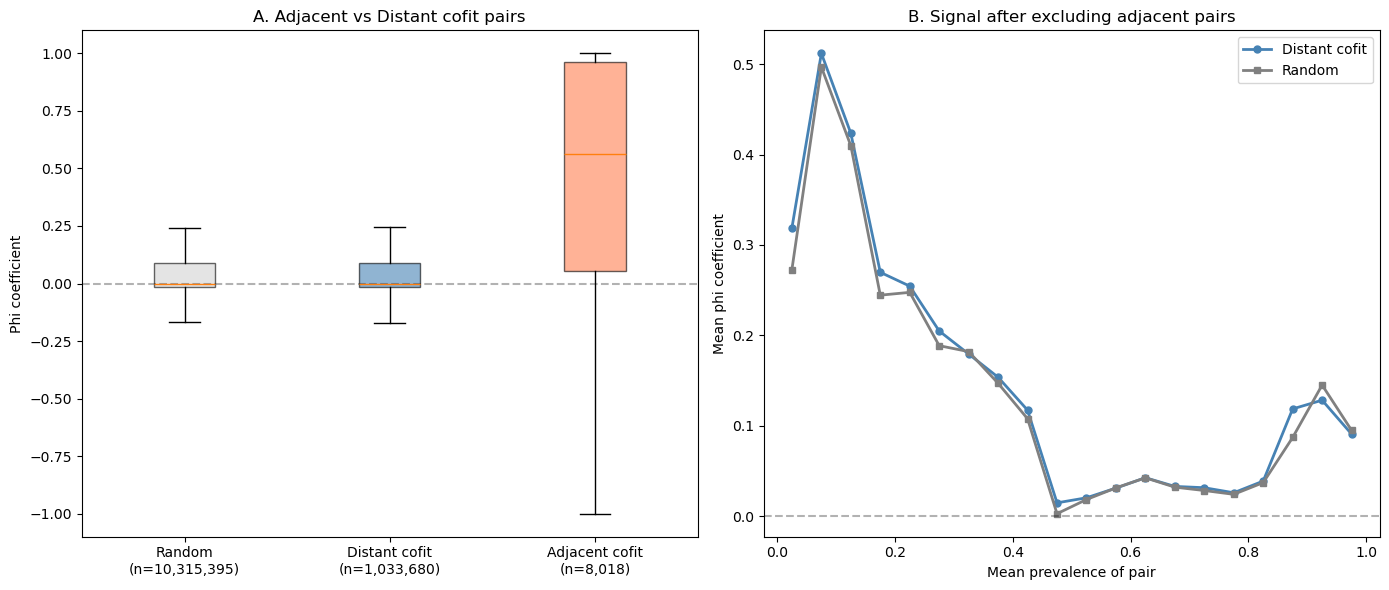


Distant cofit vs Random: U=5343117431152, p=1.13e-04
  Distant cofit mean phi: 0.0885
  Random mean phi: 0.0886
  Signal retained: -3% of full signal


In [3]:
# Separate adjacent and distant cofit pairs
cofit_all = combined[combined['is_cofit']]
n_adj = cofit_all['adjacent'].sum()
n_dist = (~cofit_all['adjacent']).sum()
print(f"Cofit pairs: {len(cofit_all):,}")
print(f"  Adjacent (<= 5 genes): {n_adj:,} ({n_adj/len(cofit_all)*100:.1f}%)")
print(f"  Distant: {n_dist:,} ({n_dist/len(cofit_all)*100:.1f}%)")

# Exclude adjacent pairs from both cofit and random
distant_cofit = combined[(combined['is_cofit']) & (~combined['adjacent'])]
random = combined[~combined['is_cofit']]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: All cofit vs adjacent-only vs distant-only
adj_phi = cofit_all[cofit_all['adjacent']]['phi'].dropna()
dist_phi = cofit_all[~cofit_all['adjacent']]['phi'].dropna()
rand_phi = random['phi'].dropna()

data = [rand_phi, dist_phi]
labels = [f'Random\n(n={len(rand_phi):,})', f'Distant cofit\n(n={len(dist_phi):,})']
if len(adj_phi) > 0:
    data.append(adj_phi)
    labels.append(f'Adjacent cofit\n(n={len(adj_phi):,})')

bp = axes[0].boxplot(data, labels=labels, patch_artist=True, showfliers=False)
box_colors = ['lightgray', 'steelblue', 'coral']
for patch, color in zip(bp['boxes'], box_colors[:len(data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Phi coefficient')
axes[0].set_title('A. Adjacent vs Distant cofit pairs')

# Panel B: Phi vs prevalence without adjacent pairs
distant_cofit_binned = distant_cofit.groupby(
    pd.cut(distant_cofit['mean_prev'], bins=bins)
)['phi'].agg(['mean', 'count'])
random_binned = random.groupby(
    pd.cut(random['mean_prev'], bins=bins)
)['phi'].agg(['mean', 'count'])

dc_valid = distant_cofit_binned[distant_cofit_binned['count'] >= min_count]
r_valid = random_binned[random_binned['count'] >= min_count]

x_dc = [bin_centers[i] for i in range(len(bin_centers))
        if distant_cofit_binned.index[i] in dc_valid.index]
x_r = [bin_centers[i] for i in range(len(bin_centers))
        if random_binned.index[i] in r_valid.index]

axes[1].plot(x_dc[:len(dc_valid)], dc_valid['mean'].values, 'o-',
             color='steelblue', linewidth=2, markersize=5, label='Distant cofit')
axes[1].plot(x_r[:len(r_valid)], r_valid['mean'].values, 's-',
             color='gray', linewidth=2, markersize=5, label='Random')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Mean prevalence of pair')
axes[1].set_ylabel('Mean phi coefficient')
axes[1].set_title('B. Signal after excluding adjacent pairs')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_operon_control.png', dpi=150, bbox_inches='tight')
plt.show()

# Test: distant cofit > random
if len(dist_phi) > 0 and len(rand_phi) > 0:
    u, p = stats.mannwhitneyu(dist_phi, rand_phi, alternative='greater')
    print(f"\nDistant cofit vs Random: U={u:.0f}, p={p:.2e}")
    print(f"  Distant cofit mean phi: {dist_phi.mean():.4f}")
    print(f"  Random mean phi: {rand_phi.mean():.4f}")
    print(f"  Signal retained: {(dist_phi.mean() - rand_phi.mean()) / (cofit_phi.mean() - rand_phi.mean()) * 100:.0f}% of full signal")

## Figure 3: Phylogenetic Control

Compute phi stratified by phylogenetic distance from the FB reference strain.

Organisms with phylogenetic data: ['Koxy', 'Btheta', 'Smeli', 'RalstoniaGMI1000', 'RalstoniaUW163', 'Putida', 'SyringaeB728a', 'Ddia6719', 'Korea']

Processing Koxy...


  Genomes with phylo distance: 399/399


  Strata computed: 2

Processing Btheta...


  Genomes with phylo distance: 287/287


  Strata computed: 2

Processing Smeli...


  Genomes with phylo distance: 241/241


  Strata computed: 2

Processing RalstoniaGMI1000...
  Genomes with phylo distance: 70/70
  Strata computed: 0

Processing RalstoniaUW163...


  Genomes with phylo distance: 0/141
  Strata computed: 0

Processing Putida...


  Genomes with phylo distance: 128/128


  Strata computed: 2

Processing SyringaeB728a...


  Genomes with phylo distance: 126/126


  Strata computed: 2

Processing Ddia6719...
  Genomes with phylo distance: 66/66


  Strata computed: 1

Processing Korea...
  Genomes with phylo distance: 72/72


  Strata computed: 1


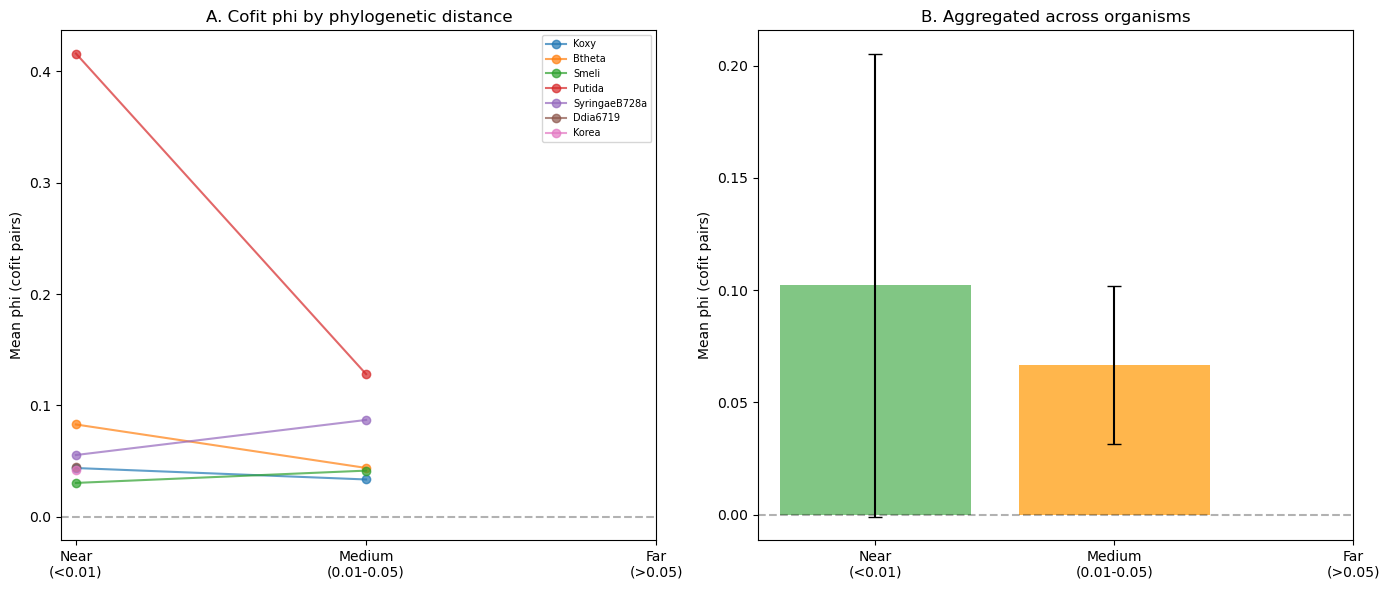


=== PHYLOGENETIC CONTROL SUMMARY ===
          n_genomes  mean_phi
stratum                      
near     132.571429  0.102228
medium    77.000000  0.066849
far             NaN       NaN


In [4]:
def strip_gtdb_prefix(genome_id):
    """Strip GB_/RS_ prefix from GTDB genome IDs to match phylo tree leaf IDs.
    
    Pangenome tables use GTDB format (GB_GCA_*, RS_GCF_*) while
    phylogenetic_tree_distance_pairs uses bare NCBI accessions (GCA_*, GCF_*).
    """
    if genome_id.startswith(('GB_', 'RS_')):
        return genome_id[3:]
    return genome_id

# Load reference genome mapping
ref_path = DATA_DIR / 'phylo_distances' / 'reference_genomes.tsv'
if not ref_path.exists():
    print("No reference genome mapping found. Skipping phylogenetic control.")
else:
    ref_genomes = pd.read_csv(ref_path, sep='\t')

    # For each organism with phylo data, stratify genomes and recompute phi
    link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
    link = link[link['orgId'] != 'Dyella79']
    link['locusId'] = link['locusId'].astype(str)

    phylo_results = []
    distance_bins = [('near', 0, 0.01), ('medium', 0.01, 0.05), ('far', 0.05, float('inf'))]

    orgs_with_phylo = [f.stem.replace('_phylo_distances', '')
                       for f in (DATA_DIR / 'phylo_distances').glob('*_phylo_distances.tsv')]
    print(f"Organisms with phylogenetic data: {orgs_with_phylo}")

    for orgId in orgs_with_phylo:
        print(f"\nProcessing {orgId}...")

        # Load data
        phylo = pd.read_csv(DATA_DIR / 'phylo_distances' / f'{orgId}_phylo_distances.tsv', sep='\t')
        matrix = pd.read_csv(
            DATA_DIR / 'genome_cluster_matrices' / f'{orgId}_presence.tsv',
            sep='\t', index_col=0
        )
        cofit = pd.read_csv(DATA_DIR / 'cofit' / f'{orgId}_cofit.tsv', sep='\t')
        cofit['locusId'] = cofit['locusId'].astype(str)
        cofit['hitId'] = cofit['hitId'].astype(str)

        # Get reference genome -- strip prefix to match phylo IDs
        ref_row = ref_genomes[ref_genomes['orgId'] == orgId]
        if len(ref_row) == 0:
            print(f"  No reference genome for {orgId}")
            continue
        ref_genome = strip_gtdb_prefix(ref_row.iloc[0]['pg_genome_id'])

        # Build mapping: stripped matrix ID -> phylo ID (for lookup)
        # Matrix uses GB_GCA_*/RS_GCF_*, phylo uses GCA_*/GCF_*
        matrix_to_stripped = {g: strip_gtdb_prefix(g) for g in matrix.index}

        # Compute distance from reference for each genome
        dist_from_ref = phylo[
            (phylo['genome1_id'] == ref_genome) | (phylo['genome2_id'] == ref_genome)
        ].copy()
        dist_from_ref['other_genome'] = dist_from_ref.apply(
            lambda r: r['genome2_id'] if r['genome1_id'] == ref_genome else r['genome1_id'],
            axis=1
        )
        genome_dist = dict(zip(dist_from_ref['other_genome'], dist_from_ref['branch_distance']))
        genome_dist[ref_genome] = 0.0

        # Stratify genomes using stripped IDs for lookup
        matrix_genomes = matrix.index.values
        n_with_dist = sum(1 for g in matrix_genomes if matrix_to_stripped[g] in genome_dist)
        print(f"  Genomes with phylo distance: {n_with_dist}/{len(matrix_genomes)}")

        # Map locus to cluster
        org_link = link[link['orgId'] == orgId][['locusId', 'gene_cluster_id']].copy()
        org_link['locusId'] = org_link['locusId'].astype(str)
        locus_to_cluster = dict(zip(org_link['locusId'], org_link['gene_cluster_id']))

        # Get cofit cluster pairs
        cluster_cols = matrix.columns.values
        cluster_idx = {c: i for i, c in enumerate(cluster_cols)}

        cofit['c1'] = cofit['locusId'].map(locus_to_cluster)
        cofit['c2'] = cofit['hitId'].map(locus_to_cluster)
        cofit_mapped = cofit.dropna(subset=['c1', 'c2'])
        cofit_mapped = cofit_mapped[
            cofit_mapped['c1'].isin(cluster_idx) & cofit_mapped['c2'].isin(cluster_idx)
        ]
        cofit_mapped = cofit_mapped[cofit_mapped['c1'] != cofit_mapped['c2']]
        pair_arr = np.sort(cofit_mapped[['c1', 'c2']].values, axis=1)
        cofit_mapped = cofit_mapped.copy()
        cofit_mapped['pair_key'] = [f"{a}_{b}" for a, b in pair_arr]
        cofit_unique = cofit_mapped.drop_duplicates('pair_key')

        # Sample up to 2000 pairs for speed
        if len(cofit_unique) > 2000:
            cofit_unique = cofit_unique.sample(2000, random_state=42)

        for bin_name, low, high in distance_bins:
            # Select genomes in this distance stratum (using stripped IDs)
            stratum_genomes = [g for g in matrix_genomes
                               if matrix_to_stripped[g] in genome_dist
                               and low <= genome_dist[matrix_to_stripped[g]] < high]
            if len(stratum_genomes) < 10:
                continue

            stratum_idx = [list(matrix_genomes).index(g) for g in stratum_genomes]
            sub_matrix = matrix.values[stratum_idx, :].astype(np.int8)

            # Compute phi for cofit pairs in this stratum
            phis = []
            for _, row in cofit_unique.iterrows():
                i1, i2 = cluster_idx[row['c1']], cluster_idx[row['c2']]
                v1 = sub_matrix[:, i1]
                v2 = sub_matrix[:, i2]
                if v1.std() > 0 and v2.std() > 0:
                    phis.append(np.corrcoef(v1, v2)[0, 1])

            if phis:
                phylo_results.append({
                    'orgId': orgId,
                    'stratum': bin_name,
                    'n_genomes': len(stratum_genomes),
                    'n_pairs': len(phis),
                    'mean_phi': np.mean(phis),
                    'median_phi': np.median(phis),
                })

        print(f"  Strata computed: {sum(1 for r in phylo_results if r['orgId'] == orgId)}")

    if phylo_results:
        phylo_df = pd.DataFrame(phylo_results)
        phylo_df.to_csv(DATA_DIR / 'phylo_stratified.tsv', sep='\t', index=False)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Panel A: per-organism
        stratum_order = ['near', 'medium', 'far']
        for i, orgId in enumerate(phylo_df['orgId'].unique()):
            org = phylo_df[phylo_df['orgId'] == orgId]
            org = org.set_index('stratum').reindex(stratum_order)
            axes[0].plot(range(len(stratum_order)), org['mean_phi'].values, 'o-',
                         label=orgId, alpha=0.7)

        axes[0].set_xticks(range(len(stratum_order)))
        axes[0].set_xticklabels(['Near\n(<0.01)', 'Medium\n(0.01-0.05)', 'Far\n(>0.05)'])
        axes[0].set_ylabel('Mean phi (cofit pairs)')
        axes[0].set_title('A. Cofit phi by phylogenetic distance')
        axes[0].legend(fontsize=7)
        axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)

        # Panel B: Aggregated
        agg = phylo_df.groupby('stratum')['mean_phi'].agg(['mean', 'sem']).reindex(stratum_order)
        x = range(len(stratum_order))
        axes[1].bar(x, agg['mean'], yerr=1.96 * agg['sem'], capsize=5,
                    color=['#4CAF50', '#FF9800', '#F44336'], alpha=0.7)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(['Near\n(<0.01)', 'Medium\n(0.01-0.05)', 'Far\n(>0.05)'])
        axes[1].set_ylabel('Mean phi (cofit pairs)')
        axes[1].set_title('B. Aggregated across organisms')
        axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)

        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'fig3_phylo_control.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("\n=== PHYLOGENETIC CONTROL SUMMARY ===")
        print(phylo_df.groupby('stratum')[['n_genomes', 'mean_phi']].mean().reindex(stratum_order).to_string())
    else:
        print("No phylogenetic distance data extracted.")

## Figure 4: Cofit Strength Predicts Co-occurrence Strength

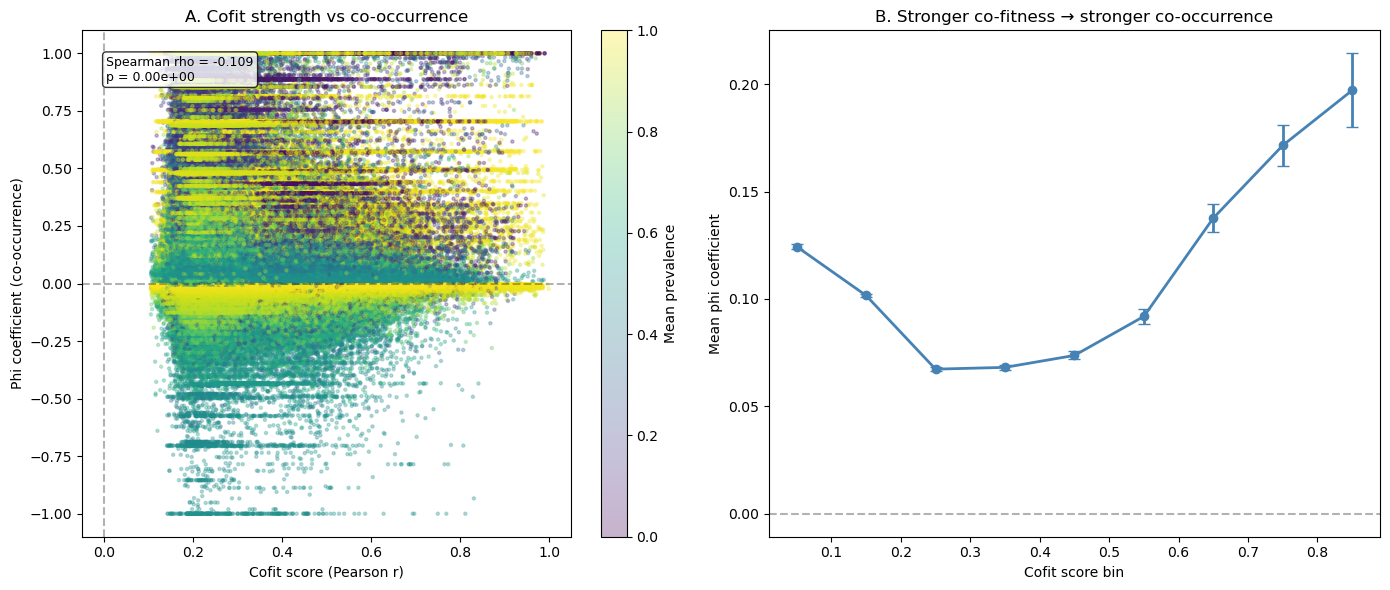

Spearman rho = -0.1086, p = 0.00e+00
N pairs: 1,041,698


In [5]:
cofit_data = combined[combined['is_cofit']].dropna(subset=['cofit_score', 'phi']).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Scatter colored by prevalence
sc = axes[0].scatter(cofit_data['cofit_score'], cofit_data['phi'],
                     c=cofit_data['mean_prev'], cmap='viridis',
                     alpha=0.3, s=5, vmin=0, vmax=1)
plt.colorbar(sc, ax=axes[0], label='Mean prevalence')
axes[0].set_xlabel('Cofit score (Pearson r)')
axes[0].set_ylabel('Phi coefficient (co-occurrence)')
axes[0].set_title('A. Cofit strength vs co-occurrence')
axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)

# Spearman correlation
rho, pval = stats.spearmanr(cofit_data['cofit_score'], cofit_data['phi'])
axes[0].text(0.05, 0.95, f'Spearman rho = {rho:.3f}\np = {pval:.2e}',
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel B: Binned cofit score vs mean phi
cofit_data['cofit_bin'] = pd.cut(cofit_data['cofit_score'],
                                  bins=np.arange(0, 1.05, 0.1))
binned = cofit_data.groupby('cofit_bin')['phi'].agg(['mean', 'sem', 'count'])
binned = binned[binned['count'] >= 10]

x = np.arange(0.05, 0.05 + len(binned) * 0.1, 0.1)[:len(binned)]
axes[1].errorbar(x, binned['mean'], yerr=1.96 * binned['sem'],
                 fmt='o-', color='steelblue', capsize=4, linewidth=2)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Cofit score bin')
axes[1].set_ylabel('Mean phi coefficient')
axes[1].set_title('B. Stronger co-fitness → stronger co-occurrence')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_cofit_strength.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Spearman rho = {rho:.4f}, p = {pval:.2e}")
print(f"N pairs: {len(cofit_data):,}")

## Figure 5: Module Co-inheritance (from NB03)

/tmp/ipykernel_41563/486172771.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Core', 'Mixed', 'Accessory'],


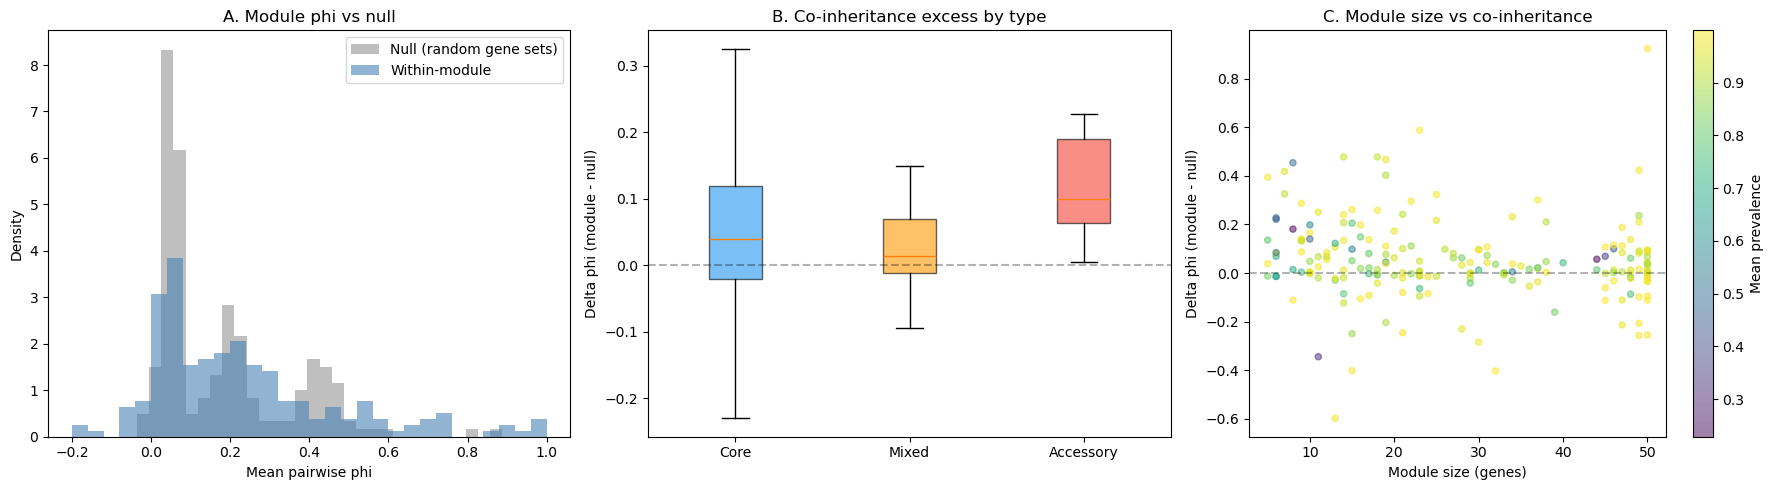

In [6]:
if module_df is not None:
    valid = module_df.dropna(subset=['mean_phi', 'null_mean'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Panel A: Distribution of module phi vs null
    axes[0].hist(valid['null_mean'], bins=30, alpha=0.5, label='Null (random gene sets)',
                 color='gray', density=True)
    axes[0].hist(valid['mean_phi'], bins=30, alpha=0.6, label='Within-module',
                 color='steelblue', density=True)
    axes[0].set_xlabel('Mean pairwise phi')
    axes[0].set_ylabel('Density')
    axes[0].set_title('A. Module phi vs null')
    axes[0].legend()

    # Panel B: Delta by module type
    type_order = ['core_module', 'mixed', 'accessory_module']
    box_data = [valid[valid['module_type'] == mt]['delta'].dropna() for mt in type_order]
    bp = axes[1].boxplot(box_data, labels=['Core', 'Mixed', 'Accessory'],
                         patch_artist=True, showfliers=False)
    for patch, color in zip(bp['boxes'], ['#2196F3', '#FF9800', '#F44336']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].set_ylabel('Delta phi (module - null)')
    axes[1].set_title('B. Co-inheritance excess by type')

    # Panel C: Module size vs co-inheritance
    axes[2].scatter(valid['n_genes'], valid['delta'],
                    c=valid['mean_prevalence'], cmap='viridis',
                    alpha=0.5, s=20)
    axes[2].set_xlabel('Module size (genes)')
    axes[2].set_ylabel('Delta phi (module - null)')
    axes[2].set_title('C. Module size vs co-inheritance')
    axes[2].axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.colorbar(axes[2].collections[0], ax=axes[2], label='Mean prevalence')

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'fig5_module_coinheritance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No module results available. Run NB03 first.")

## Figure 6: Functional Interpretation

What functional categories are enriched among co-inherited co-fit gene pairs?

High phi (>0.092) AND high cofit (>0.373): 56,531 pairs


Annotated high pairs: 52,977


/tmp/ipykernel_41563/4283347779.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(cat_phi, labels=top_cats, patch_artist=True,


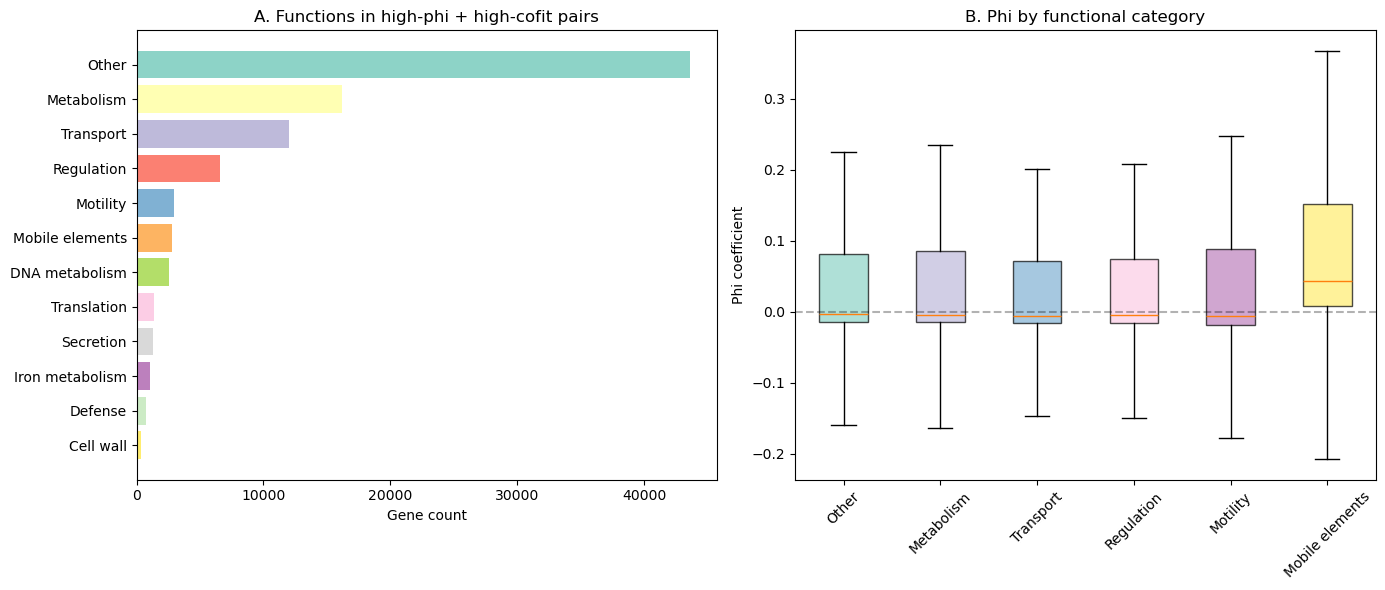


=== TOP FUNCTIONAL CATEGORIES ===
category
Other              43584
Metabolism         16221
Transport          12017
Regulation          6558
Motility            2929
Mobile elements     2771
DNA metabolism      2551
Translation         1405
Secretion           1262
Iron metabolism     1023
Defense              764
Cell wall            322


In [7]:
# Identify high-phi + high-cofit pairs
cofit_data = combined[combined['is_cofit']].dropna(subset=['phi', 'cofit_score']).copy()

# Thresholds: top quartile of both phi and cofit
phi_thresh = cofit_data['phi'].quantile(0.75)
cofit_thresh = cofit_data['cofit_score'].quantile(0.75)

high_both = cofit_data[
    (cofit_data['phi'] >= phi_thresh) & (cofit_data['cofit_score'] >= cofit_thresh)
]
print(f"High phi (>{phi_thresh:.3f}) AND high cofit (>{cofit_thresh:.3f}): {len(high_both):,} pairs")

# Annotate with SEED
seed_dict = dict(zip(
    seed['orgId'] + '_' + seed['locusId'].astype(str),
    seed['seed_desc']
))

high_both['desc1'] = (high_both['orgId'] + '_' + high_both['locusId1'].astype(str)).map(seed_dict)
high_both['desc2'] = (high_both['orgId'] + '_' + high_both['locusId2'].astype(str)).map(seed_dict)

annotated = high_both[high_both['desc1'].notna() | high_both['desc2'].notna()]
print(f"Annotated high pairs: {len(annotated):,}")

# Extract functional keywords
def extract_category(desc):
    """Extract broad functional category from SEED description."""
    if pd.isna(desc):
        return 'Unknown'
    desc_lower = desc.lower()
    if any(k in desc_lower for k in ['transport', 'permease', 'abc', 'efflux', 'porin']):
        return 'Transport'
    if any(k in desc_lower for k in ['flagell', 'motil', 'chemotax', 'pili', 'fimb']):
        return 'Motility'
    if any(k in desc_lower for k in ['ribosom', 'trna', 'rrna', 'translation']):
        return 'Translation'
    if any(k in desc_lower for k in ['transcri', 'regula', 'repres', 'activat', 'sigma']):
        return 'Regulation'
    if any(k in desc_lower for k in ['phage', 'mobile', 'transpos', 'integrase', 'insertion']):
        return 'Mobile elements'
    if any(k in desc_lower for k in ['secreti', 'type ii', 'type iii', 'type iv', 'type vi']):
        return 'Secretion'
    if any(k in desc_lower for k in ['siderophore', 'iron', 'fe-s', 'ferr']):
        return 'Iron metabolism'
    if any(k in desc_lower for k in ['resist', 'beta-lacta', 'antibiotic', 'multidrug']):
        return 'Defense'
    if any(k in desc_lower for k in ['dehydrogenase', 'oxidoreductase', 'kinase', 'synthase', 'transferase']):
        return 'Metabolism'
    if any(k in desc_lower for k in ['cell wall', 'lipopoly', 'peptidoglycan', 'capsul']):
        return 'Cell wall'
    if any(k in desc_lower for k in ['dna', 'repair', 'replicat', 'recomb']):
        return 'DNA metabolism'
    return 'Other'

# Categorize both genes in each pair
all_descs = pd.concat([
    high_both[['desc1']].rename(columns={'desc1': 'desc'}),
    high_both[['desc2']].rename(columns={'desc2': 'desc'}),
])
all_descs['category'] = all_descs['desc'].apply(extract_category)

# Also categorize random baseline
random_data = combined[~combined['is_cofit']].dropna(subset=['phi'])

# Count categories in high-phi cofit pairs
cat_counts = all_descs['category'].value_counts()
cat_counts = cat_counts[cat_counts.index != 'Unknown']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Category distribution
colors = plt.cm.Set3(np.linspace(0, 1, len(cat_counts)))
axes[0].barh(range(len(cat_counts)), cat_counts.values, color=colors)
axes[0].set_yticks(range(len(cat_counts)))
axes[0].set_yticklabels(cat_counts.index)
axes[0].set_xlabel('Gene count')
axes[0].set_title('A. Functions in high-phi + high-cofit pairs')
axes[0].invert_yaxis()

# Panel B: Phi distribution by category (for annotated cofit pairs)
cofit_data_cat = cofit_data.copy()
cofit_data_cat['cat1'] = (cofit_data_cat['orgId'] + '_' + cofit_data_cat['locusId1'].astype(str)).map(seed_dict).apply(extract_category)
# Use gene 1 category for simplicity
top_cats = cat_counts.head(6).index.tolist()
cat_phi = []
for cat in top_cats:
    sub = cofit_data_cat[cofit_data_cat['cat1'] == cat]['phi'].dropna()
    cat_phi.append(sub)

bp = axes[1].boxplot(cat_phi, labels=top_cats, patch_artist=True,
                     showfliers=False, vert=True)
for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(top_cats)))):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Phi coefficient')
axes[1].set_title('B. Phi by functional category')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig6_functional.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== TOP FUNCTIONAL CATEGORIES ===")
print(cat_counts.to_string())

## Summary Statistics Table

In [8]:
# Per-organism effect sizes
summary = pd.read_csv(DATA_DIR / 'organism_summary.tsv', sep='\t')

print("=== PER-ORGANISM EFFECT SIZES ===")
print(summary.to_string(index=False, float_format='%.4f'))

print(f"\n=== AGGREGATE STATISTICS ===")
print(f"Organisms: {len(summary)}")
print(f"Mean delta phi: {summary['delta_phi'].mean():.4f} +/- {summary['delta_phi'].sem():.4f}")
print(f"Organisms with positive delta: {(summary['delta_phi'] > 0).sum()}/{len(summary)}")
print(f"Organisms with p < 0.05: {(summary['pval'] < 0.05).sum()}/{len(summary)}")

# Signed-rank test: is delta consistently positive?
if len(summary) >= 5:
    w_stat, w_pval = stats.wilcoxon(summary['delta_phi'].dropna())
    print(f"Wilcoxon signed-rank (delta > 0): W={w_stat:.0f}, p={w_pval:.4f}")

=== PER-ORGANISM EFFECT SIZES ===
        orgId  n_cofit  n_random  mean_phi_cofit  mean_phi_random  delta_phi   pval  pct_adjacent
         Koxy   162160   1591269          0.0410           0.0378     0.0032 0.0330        0.7215
       Btheta   242676   2432473          0.0673           0.0668     0.0005 0.0000        0.7534
        Smeli   230516   2274629          0.0286           0.0263     0.0024 0.0000        0.4558
       Putida   205323   2056242          0.1708           0.1709    -0.0001 0.4136        0.8067
SyringaeB728a   129385   1232384          0.0485           0.0428     0.0057 0.0003        0.5317
        Korea     7994     73267          0.4474           0.4888    -0.0415 0.0000        0.9226
        Phaeo    14728    130956          0.2307           0.2220     0.0087 0.0007        1.6870
     Ddia6719    16957    186371          0.1817           0.0891     0.0926 0.0000        0.5060
 pseudo3_N2E3    31959    337804          0.4582           0.4325     0.0258 0.0000 

In [9]:
print('=' * 60)
print('NB04 SUMMARY: Cross-Organism Synthesis')
print('=' * 60)
print(f'Organisms analyzed: {combined["orgId"].nunique()}')
print(f'Total pairs: {len(combined):,}')
cofit = combined[combined['is_cofit']]
rand = combined[~combined['is_cofit']]
print(f'Overall delta phi: {cofit["phi"].mean() - rand["phi"].mean():.4f}')
u, p = stats.mannwhitneyu(cofit['phi'].dropna(), rand['phi'].dropna(), alternative='two-sided')
print(f'Mann-Whitney p (two-sided): {p:.2e}')
if module_df is not None:
    valid = module_df.dropna(subset=['mean_phi', 'null_mean'])
    print(f'Module delta: {valid["delta"].mean():.4f}')
    print(f'Significant modules: {(valid["pval"] < 0.05).sum()}/{len(valid)}')
print(f'\nFigures saved to: {FIGURES_DIR}')
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f'  {f.name}')
print('=' * 60)

NB04 SUMMARY: Cross-Organism Synthesis


Organisms analyzed: 9
Total pairs: 24,788,401


Overall delta phi: 0.0032


Mann-Whitney p (two-sided): 1.66e-29
Module delta: 0.0527
Significant modules: 51/195

Figures saved to: ../figures
  fig1_cofit_cooccurrence.png
  fig2_operon_control.png
  fig3_phylo_control.png
  fig4_cofit_strength.png
  fig5_module_coinheritance.png
  fig6_functional.png
  module_coinheritance.png
  quick_cooccurrence.png
